In [1]:
from __future__ import print_function
#%matplotlib inline
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from tqdm import tqdm

from scipy import linalg


In [2]:
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
nz = 128

In [3]:
from models.generator_3_0_2 import * 
netG = Generator().to(device)

In [4]:
from models.discriminator_2 import *
netD = Discriminator().to(device)

In [5]:
checkpoint = torch.load('utils/saved_models/last_saved_model_100_good.tar')
netG.load_state_dict(checkpoint['netG_state_dict'])

<All keys matched successfully>

In [6]:
fixed_noise = torch.randn(4, nz, device=device)
#fixed_noise = torch.randn(4, nz, 1, 1, device=device) #gen1

In [7]:
with torch.no_grad():
    test_image = netG.forward(fixed_noise).detach().cpu()

In [8]:
print(test_image.shape)

torch.Size([4, 3, 64, 64])


# Generated LR images

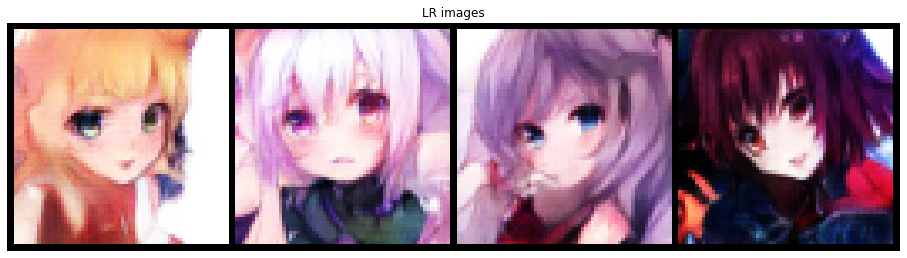

In [9]:
# Plot some training images
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("LR images")

plt.imshow(np.transpose(vutils.make_grid(test_image, padding=2, normalize=True).cpu(),(1,2,0)))

In [10]:
minimo = torch.min(test_image)
massimo = torch.max(test_image)
print(minimo, massimo)
print(test_image.shape)
print(list(test_image[0][0][0][0].shape))

tensor(-0.9985) tensor(1.)
torch.Size([4, 3, 64, 64])
[]


In [11]:
def normalizza(tensore, minimo, massimo):
    #recompute each value of the tensor to a range between 0 and 1
    for f in range(list(test_image.shape)[0]): #32 tensori
        for i in range(list(test_image[0].shape)[0]): #3 canali
            for g in range(list(test_image[0][0].shape)[0]): #64
                for o in range(list(test_image[0][0][0].shape)[0]): #x64
                    temp = tensore[f][i][g][o]
                    normalizzato = (temp - minimo)/(massimo - minimo)
                    tensore[f][i][g][o] = normalizzato
    
    return tensore                   

In [12]:
new_image = normalizza(test_image, minimo, massimo)
minimum = torch.min(new_image)
maximum = torch.max(new_image)
print(minimum, maximum)

tensor(0.) tensor(1.)


In [13]:
from models.generator_srgan import Generator
netSRG = Generator().to(device)

In [14]:
netSRG.load_state_dict(torch.load('utils/cp/netG_epoch_5_smallData.pth'))

<All keys matched successfully>

In [15]:
with torch.no_grad():
    new_image.to(device)
    print(test_image.shape)
    sr_image = netSRG(new_image).detach().cpu()

torch.Size([4, 3, 64, 64])


# SR images

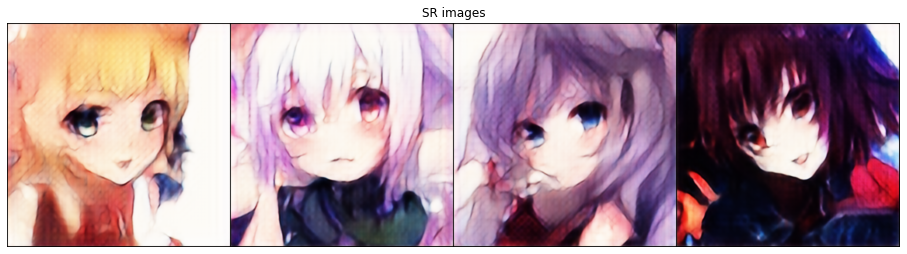

In [16]:
# Plot some training images
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("SR images")
plt.imshow(np.transpose(vutils.make_grid(sr_image, padding=2, normalize=True).cpu(),(1,2,0)))

# Comparing results

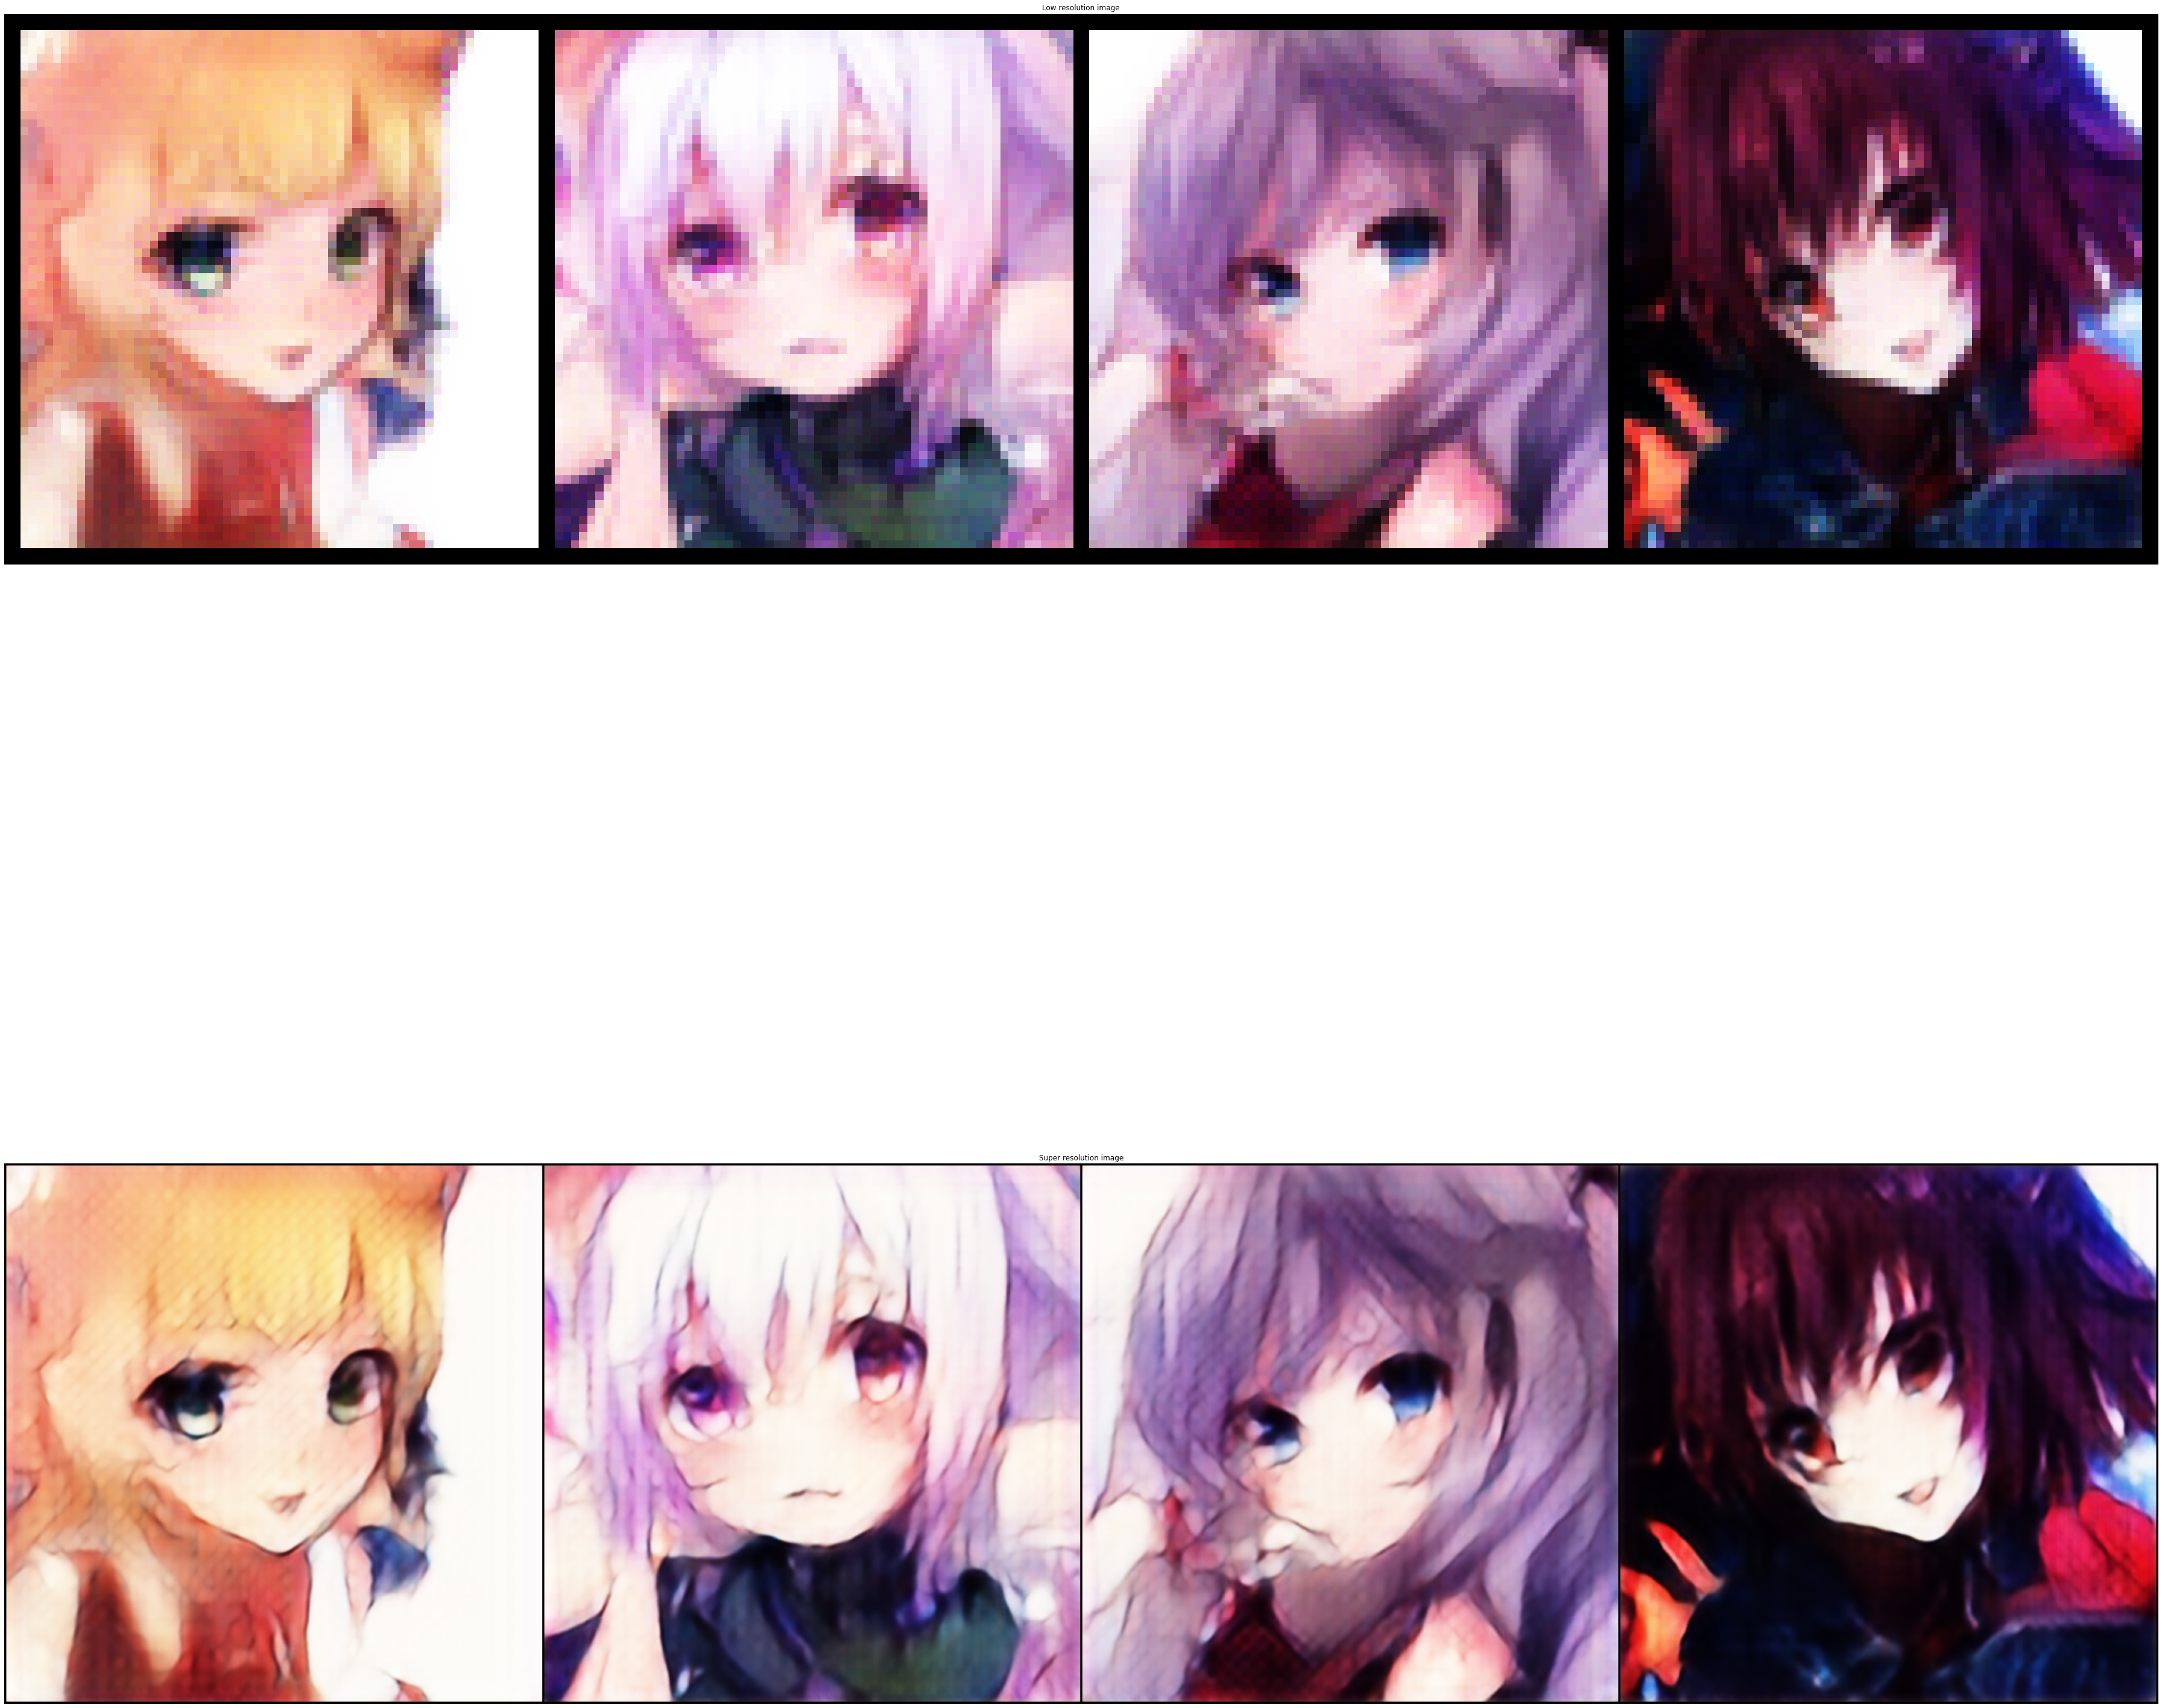

In [17]:
plt.figure(figsize=(64,64))
plt.subplot(2,1,1)
plt.axis("off")
plt.title("Low resolution image")
plt.imshow(np.transpose(vutils.make_grid(test_image, padding=2, normalize=True).cpu(),(1,2,0)))
plt.subplot(2,1,2)
plt.axis("off")
plt.title("Super resolution image")
plt.imshow(np.transpose(vutils.make_grid(sr_image, padding=2, normalize=True).cpu(),(1,2,0)))